In [1]:
import numpy as np
from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL

In [2]:
# 2 unknown
matrix = np.array([[1.5, 0.5],[0.5, 1.5]])


vector = np.array([1,0])

In [3]:
hhl = HHL().solve(matrix,vector)

## Classical Method
For the classical solver we need to rescale the right hand side (i.e. vector / np.linalg.norm(vector)) to take into account the renormalisation that occurs once vector is encoded in a quantum state within HHL.

In [4]:
classical = NumPyLinearSolver().solve(matrix, vector/ np.linalg.norm(vector))

 HHL algorithm can find a solution exponentially faster in the size of the system than their classical counterparts (i.e. logarithmic complexity instead of polynomial). However the cost for this exponential speedup is that we do not obtain the full solution vector. Instead, we obtain a quantum state representing the vector  
x
  and learning all the components of this vector would take a linear time in its dimension, diminishing any speedup obtained by the quantum algorithm.

Therefore, we can only compute functions from  
x
  (the so called observables) to learn information about the solution. This is reflected in the LinearSolverResult object returned by solve(), which contains the following properties

<li>state: either the circuit that prepares the solution or the solution as a vector
<li>euclidean_norm: the euclidean norm if the algorithm knows how to calculate it
<li>observable: the (list of) calculated observable(s)
<li>circuit_results: the observable results from the (list of) circuit(s)

In [5]:
# the classical soln will return an array
print("Classical Way", classical.state)

Classical Way [ 0.75 -0.25]


In [6]:
# for the Quantum Method, we will get the circuits
print("Quantum Way", hhl.state)

Quantum Way       ┌───────────┐┌──────┐        ┌─────────┐
q0_0: ┤ circuit-7 ├┤2     ├────────┤2        ├
      └───────────┘│      │┌──────┐│         │
q1_0: ─────────────┤0 QPE ├┤1     ├┤0 QPE_dg ├
                   │      ││      ││         │
q1_1: ─────────────┤1     ├┤0 1/x ├┤1        ├
                   └──────┘│      │└─────────┘
q2_0: ─────────────────────┤2     ├───────────
                           └──────┘           


In [7]:
# comparing the Accuracy
print('classical Euclidean norm:', classical.euclidean_norm)
print('naive Euclidean norm:', hhl.euclidean_norm)


classical Euclidean norm: 0.7905694150420949
naive Euclidean norm: 0.7905694150420939


## Comparing the Solution Vector-Wise

In [8]:
from qiskit.quantum_info import Statevector

hhl_sv = Statevector(hhl.state).data


# Extract the right vector components. 1000 corresponds to the index 8 and 1001 corresponds to the index 9
hhl_vector = np.array([hhl_sv[8], hhl_sv[9]])

print('HHL Vector Solution:', hhl_vector)


HHL Vector Solution: [ 0.75-1.06454051e-16j -0.25+1.20929103e-17j]


The imaginary part is very small, most likely due to computer accuracy, and can be disregarded in this case.

In [9]:
hhl_vector = np.real(hhl_vector)
print("HHL Vector",hhl_vector)

HHL Vector [ 0.75 -0.25]


In [10]:
# and the classical Vector
print("Classical Vector", classical.state)

Classical Vector [ 0.75 -0.25]


## Using different $|b\rangle$ vectors

In [11]:
vector_3 =  np.array([0.440,-0.898])

vector_4 =  np.array([0.960,-0.281])


vector_2 = np.array([0.707,0.707])

In [12]:
def hhl_two_unknown(matrix, vector):
    hhl = HHL().solve(matrix,vector)
    
    
    classical = NumPyLinearSolver().solve(matrix, vector/ np.linalg.norm(vector))
    # comparing the Accuracy
    accuracy_hhl = hhl.euclidean_norm
    accuracy_classical = classical.euclidean_norm
    
    hhl_sv = Statevector(hhl.state).data


# Extract the right vector components. 1000 corresponds to the index 8 and 1001 corresponds to the index 9
    hhl_vector = np.array([hhl_sv[8], hhl_sv[9]])
    hhl_vector = np.real(hhl_vector)
    
    
    return("HHl Vector",hhl_vector)


    

In [13]:
hhl_two_unknown(matrix, vector_2)

('HHl Vector', array([0.35355339, 0.35355339]))

In [14]:
def classical_way(matrix, vector):
    classical = NumPyLinearSolver().solve(matrix, vector/ np.linalg.norm(vector))
    
    return("Classical Vector",classical.state)

HHL Vector is exact because all the default methods used are exact. But what if we use a bigger matrix?

In [ ]:
classical_way(matrix, vector_2)

In [ ]:
hhl_two_unknown(matrix, vector_3)

In [17]:

classical_way(matrix, vector_3)

('Classical Vector', array([ 0.55449889, -0.78349843]))

In [18]:
hhl_two_unknown(matrix, vector_4)

('HHl Vector', array([ 0.79002843, -0.45062362]))

In [19]:

classical_way(matrix, vector_4)

('Classical Vector', array([ 0.79002843, -0.45062362]))

## Doing it for a 4 \times 4 matrix

In [20]:
from scipy.sparse import diags

num_qubits = 2
matrix_size = 2 ** num_qubits
# entries of the tridiagonal Toeplitz symmetric matrix
a = 1
b = -1/3

matrix = diags([b, a, b], [-1, 0, 1], shape=(matrix_size, matrix_size)).toarray()
vector = np.array([1] + [0]*(matrix_size - 1))

# run the algorithms
classical_solution = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector))
naive_hhl_solution = HHL().solve(matrix, vector)

print('classical euclidean norm:', classical_solution.euclidean_norm)
print('naive euclidean norm:', naive_hhl_solution.euclidean_norm)


classical euclidean norm: 1.237833351044751
naive euclidean norm: 1.243808933128547


In [21]:
print(matrix)
print(vector)

[[ 1.         -0.33333333  0.          0.        ]
 [-0.33333333  1.         -0.33333333  0.        ]
 [ 0.         -0.33333333  1.         -0.33333333]
 [ 0.          0.         -0.33333333  1.        ]]
[1 0 0 0]


In [22]:
from qiskit.algorithms.linear_solvers.observables import AbsoluteAverage, MatrixFunctional

Euclidean norm for a vector  $x=(x_1,....,x_N)$
  is defined as  $||x||=\sqrt{\sum^N_{i=1}x^2_i}$ . 
  
  Therefore, the probability of measuring  $1$  in the auxiliary qubit is the squared norm of  $x$ . This means that the HHL algorithm can always calculate the euclidean norm of the solution and we can compare the accuracy of the results

In [23]:
average_solution = HHL().solve(matrix, vector, AbsoluteAverage())
classical_average = NumPyLinearSolver().solve(matrix, vector / np.linalg.norm(vector), AbsoluteAverage())


In [24]:
print('quantum average:', average_solution.observable)
print('classical average:', classical_average.observable)
print('quantum circuit results:', average_solution.circuit_results)

quantum average: 0.4522866685211148
classical average: 0.45
quantum circuit results: (0.1736360026908816+0j)


Depth: 26
CNOTS: 10


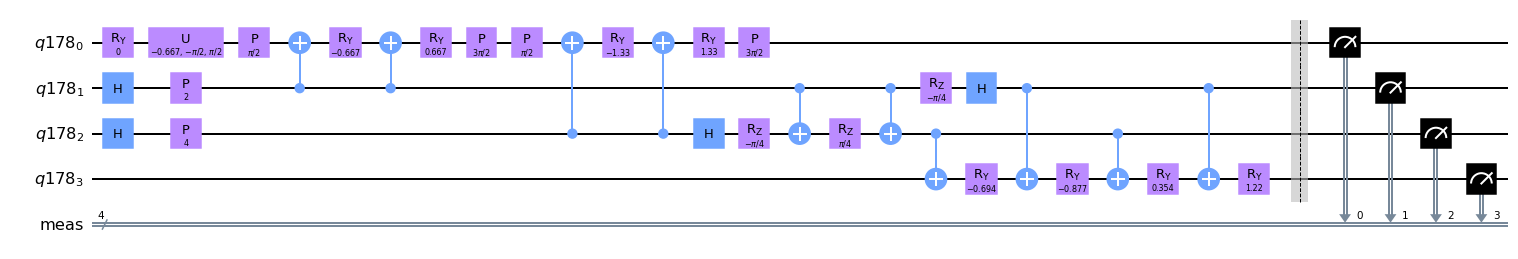

In [25]:
from qiskit import QuantumRegister, QuantumCircuit
import numpy as np

t = 2  # This is not optimal; As an exercise, set this to the
       # value that will get the best results. See section 8 for solution.

nqubits = 4  # Total number of qubits
nb = 1  # Number of qubits representing the solution
nl = 2  # Number of qubits representing the eigenvalues

theta = 0  # Angle defining |b>

a = 1  # Matrix diagonal
b = -1/3  # Matrix off-diagonal

# Initialize the quantum and classical registers
qr = QuantumRegister(nqubits)

# Create a Quantum Circuit
qc = QuantumCircuit(qr)

qrb = qr[0:nb]
qrl = qr[nb:nb+nl]
qra = qr[nb+nl:nb+nl+1]

# State preparation. 
qc.ry(2*theta, qrb[0])
    
# QPE with e^{iAt}
for qu in qrl:
    qc.h(qu)

qc.p(a*t, qrl[0])
qc.p(a*t*2, qrl[1])

qc.u(b*t, -np.pi/2, np.pi/2, qrb[0])


# Controlled e^{iAt} on \lambda_{1}:
params=b*t

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Controlled e^{2iAt} on \lambda_{2}:
params = b*t*2

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Inverse QFT
qc.h(qrl[1])
qc.rz(-np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(-np.pi/4,qrl[0])
qc.h(qrl[0])

# Eigenvalue rotation
t1=(-np.pi +np.pi/3 - 2*np.arcsin(1/3))/4
t2=(-np.pi -np.pi/3 + 2*np.arcsin(1/3))/4
t3=(np.pi -np.pi/3 - 2*np.arcsin(1/3))/4
t4=(np.pi +np.pi/3 + 2*np.arcsin(1/3))/4

qc.cx(qrl[1],qra[0])
qc.ry(t1,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t2,qra[0])
qc.cx(qrl[1],qra[0])
qc.ry(t3,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t4,qra[0])
qc.measure_all()

print("Depth: %i" % qc.depth())
print("CNOTS: %i" % qc.count_ops()['cx'])
qc.draw(fold=-1)

In [30]:
from qiskit import ClassicalRegister, IBMQ
from qiskit.compiler import transpile
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, # Measurement error mitigation functions
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')

#backend = provider.get_backend('ibm-q') # calibrate using real hardware
layout = [2,3,0,4]
chip_qubits = 5

# Transpiled circuit for the real hardware
qc_qa_cx = transpile(qc, backend=backend, initial_layout=layout)

ibmqfactory.load_account:WARNING:2021-08-18 19:38:15,803: Credentials are already in use. The existing account in the session will be replaced.


Traceback (most recent call last):
  File "<ipython-input-30-ff95f5f05eb5>", line 8, in <module>
    backend = provider.get_backend('ibmq_vigo')
  File "/opt/conda/lib/python3.8/site-packages/qiskit/providers/provider.py", line 55, in get_backend
    raise QiskitBackendNotFoundError("No backend matches the criteria")
QiskitBackendNotFoundError: 'No backend matches the criteria'

Use %tb to get the full traceback.


In [28]:
from qiskit import IBMQ

# IBMQ.save_account(TOKEN)
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

ibmqfactory.load_account:WARNING:2021-08-18 19:37:19,164: Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]